In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Implementation of CIC in TF

In [2]:
import tensorflow as tf

In [309]:
def cic_paint(mesh, part, weight, cube_size=None):
    
    # Create a variable to store the input mesh
    var = tf.Variable(0 ,dtype=tf.float32)
    var = tf.assign(var, mesh, validate_shape=False)
    
    # Extract the indices of all the mesh points affected by each particles
    i000 = tf.cast(tf.floor(part), dtype=tf.int32)
    i100 = i000 + tf.constant([1, 0, 0])
    i010 = i000 + tf.constant([0, 1, 0])
    i001 = i000 + tf.constant([0, 0, 1])
    i110 = i000 + tf.constant([1, 1, 0])
    i101 = i000 + tf.constant([1, 0, 1])
    i011 = i000 + tf.constant([0, 1, 1])
    i111 = i000 + tf.constant([1, 1, 1])
    neighboor_coords = tf.stack([i000, i100, i010, i001,
                                 i110, i101, i011, i111], axis=1)
    
    kernel = 1. - tf.abs(tf.expand_dims(part, axis=1) - tf.cast(neighboor_coords, tf.float32))
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    kernel = tf.expand_dims(weight, axis=1) * kernel
    
    
    if cube_size is not None:
        neighboor_coords = neighboor_coords % cube_size
    
    updated_mesh = tf.scatter_nd_add(var, tf.reshape(neighboor_coords, (-1,3)),  tf.reshape(kernel, (-1,)))
    return updated_mesh

In [214]:
cube = randn(32,32,32).astype('float32')

In [289]:
part = array([[15,15,15], [0,32.5,0]]).reshape((-1,3)).astype('float32')
weight = ones(len(part)).astype('float32')

In [290]:
c = tf.placeholder(dtype=float32, shape=[None,None,None])
p = tf.placeholder(dtype=float32, shape=[None, 3])
w = tf.placeholder(dtype=float32, shape=[None])
painted = cic_paint(cube, part, weight,cube_size=32)

In [291]:
sess = tf.Session()

In [292]:
toti = sess.run(painted, feed_dict={c:cube, p:part, w:weight})

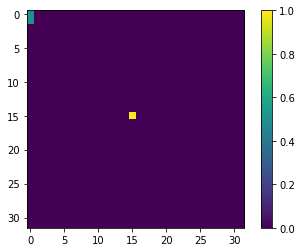

In [293]:
imshow((toti - cube).sum(axis=0));colorbar()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]
rprob = 0.95

In [114]:
suff = '-pad2'
num_cubes= 1000
cube_size = 32
pad = 2
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

In [115]:
meshes = {}
cube_features, cube_target = [], []

In [116]:
seed =100

In [117]:
mesh = {}
partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
mesh['cic'] = tools.paintcic(partp, bs, ncp)
#mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
#mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
#mesh['GD'] = mesh['R1'] - mesh['R2']

In [118]:
bs

400

In [119]:
((partp/bs*128) % 128)

array([[1.01638064e+00, 1.26354306e+02, 1.99633588e-01],
       [1.59055195e+00, 1.26434898e+02, 1.40365880e+00],
       [2.47809796e+00, 1.26602726e+02, 3.19101792e+00],
       ...,
       [1.27751589e+02, 1.25578571e+02, 1.25663161e+02],
       [1.27651592e+02, 1.25258645e+02, 1.27424278e+02],
       [1.27541673e+02, 1.25012012e+02, 6.18227858e-02]])

In [202]:
test_cic = tools.paintcic(partp, bs, ncp, period=True)

In [203]:
test_cic.shape

(128, 128, 128)

In [310]:
c = tf.placeholder(dtype=float32, shape=[None,None,None])
p = tf.placeholder(dtype=float32, shape=[None, 3])
w = tf.placeholder(dtype=float32, shape=[None])
painted = cic_paint(c, p, w, cube_size=128)

In [311]:
transform = lambda x: x/bs*nc
xpart = transform(partp)
res = sess.run(painted, {c:zeros_like(test_cic), p:xpart, w:ones(len(partp))})

In [312]:
toto = partp/bs*128

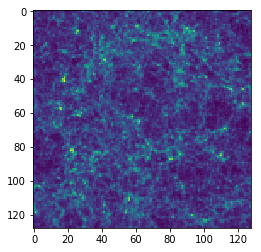

In [313]:
imshow(res.sum(axis=0))

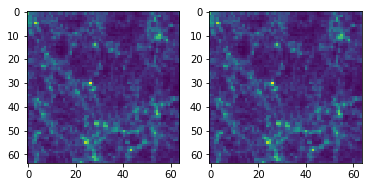

In [314]:
subplot(121)
imshow(test_cic[32:-32,32:-32,32:-32].sum(axis=0))
subplot(122)
imshow(res[32:-32,32:-32,32:-32].sum(axis=0))

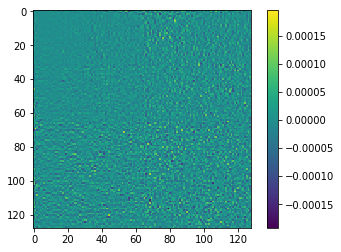

In [319]:
imshow((res-test_cic).sum(axis=0));colorbar()

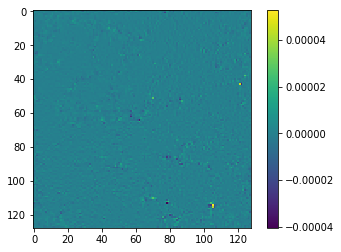

In [318]:
imshow((res-test_cic)[0,:,:]);colorbar()

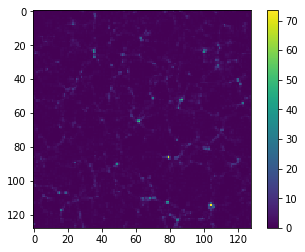

In [240]:
imshow(test_cic[0]);colorbar()

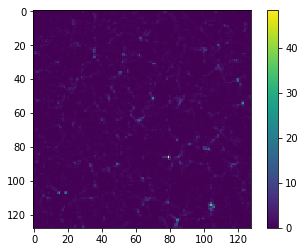

In [242]:
imshow(res[0]);colorbar()

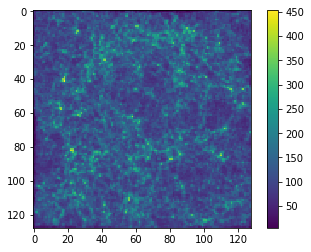

In [167]:
imshow(res.sum(axis=0));colorbar()

## Testing fastpm

In [323]:
import sys
sys.path.append('/home/francois/repo/vmad')
from pprint import pprint
from vmad.lib import fastpm, linalg
import numpy
from vmad import autooperator
from vmad.testing import BaseScalarTest
from numpy.testing import assert_allclose

In [330]:
pm = fastpm.ParticleMesh(Nmesh=[32, 32, 32], BoxSize=8.0)

In [331]:
x = pm.generate_whitenoise(seed=300, unitary=True, mode='real')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: mode argument is deprecated, use type
  """Entry point for launching an IPython kernel.


In [332]:
pos = pm.generate_uniform_particle_grid(shift=0.5)

In [361]:
x

RealField:array([[[  61.16917763,   46.55231239,  199.59027787, ...,
           28.28697114, -182.02873066,  -86.64791531],
        [ 138.21572634, -205.69978457,  164.87071258, ...,
          -72.11159608,  -15.33562995,  -10.33148263],
        [ 229.6383179 , -247.48459882,  127.67103243, ...,
          -52.71872353, -178.88758662, -193.62752782],
        ...,
        [-347.14668596, -153.09809736,  118.68552881, ...,
         -304.52033406,  -35.16192565,  -54.3446105 ],
        [  73.11046564,  244.45198047,  138.34866616, ...,
           52.95805924,  -60.95743613,   81.06817626],
        [ 373.57355864,  116.11820453, -392.10692521, ...,
         -176.92841808,  120.37079445,  111.91010929]],

       [[ 128.82998618, -136.51620658, -183.49813674, ...,
           37.2642397 ,  -17.11803093,  -60.83037501],
        [ 314.85911315,   18.11872473,   51.84278271, ...,
           59.0674735 , -119.70669517, -186.15072265],
        [-228.68675631,  164.62379252, -536.43401854, ...,
    

In [377]:
from vmad import Builder

from nbodykit.cosmology import Planck15, LinearPower

In [378]:
pm = fastpm.ParticleMesh([32, 32, 32], BoxSize=128.)
powerspectrum = LinearPower(Planck15, 0)

q = pm.generate_uniform_particle_grid()

In [379]:
q

array([[  2.,   2.,   2.],
       [  2.,   2.,   6.],
       [  2.,   2.,  10.],
       ...,
       [126., 126., 118.],
       [126., 126., 122.],
       [126., 126., 126.]])

In [380]:
with Builder() as model:
    x = model.input('x')

    wnk = fastpm.as_complex_field(x, pm)

    rhok = fastpm.induce_correlation(wnk, powerspectrum, pm)
    dx1, dx2 = fastpm.lpt(rhok, q, pm)
    dx, p, f = fastpm.nbody(rhok, q, [0.1, 0.6, 1.0], Planck15, pm)
    dx0, p0, f0 = fastpm.nbody(rhok, q, [0.1], Planck15, pm)
    model.output(dx1=dx1, dx2=dx2, dx=dx, p=p, dx0=dx0, p0=p0, f0=f0, f=f)


In [383]:

wn = pm.generate_whitenoise(555, unitary=True)
x = wn[...]

x = numpy.stack([x.real, x.imag], -1)


In [384]:
dx1, dx2 = model.compute(['dx1', 'dx2'], init=dict(x=x))

/home/francois/repo/vmad/vmad/lib/fastpm.py:26: DeprecationWarning: argument mode is deprecated. use type=complex instead
  y = pm.create(mode='complex')


ModuleNotFoundError: No module named 'fastpm'

In [367]:
# Let's try applying the fourier laplace filter
rhok = fastpm.r2c(x)

In [374]:
p = fastpm.apply_transfer(rhok, fastpm.fourier_space_laplace)


p.compute()

AttributeError: 'Symbol' object has no attribute 'compute'

In [373]:
p.eval()

TypeError: eval() missing 1 required positional argument: 'function'

In [360]:
# Builds the filters in Fourier space
k1, k2, k3 = np.meshgrid(np.fft.fftfreq(pm.Nmesh[0]), np.fft.fftfreq(pm.Nmesh[1]), np.fft.fftfreq(pm.Nmesh[2]))

denom = k1*k1 + k2*k2 + k3*k3
denom[0, 0, 0] = 1  # avoid division by 0
kernel_laplace = -1 / denom
kernel_laplace[0, 0, 0] = 0



In [353]:
def lpt1(rhok, q, pm):
    
    # apply fourier space laplace
    p = rhok * 

In [354]:
k = fftfreq(32,32)

In [355]:
k

array([ 0.        ,  0.00097656,  0.00195312,  0.00292969,  0.00390625,
        0.00488281,  0.00585938,  0.00683594,  0.0078125 ,  0.00878906,
        0.00976562,  0.01074219,  0.01171875,  0.01269531,  0.01367188,
        0.01464844, -0.015625  , -0.01464844, -0.01367188, -0.01269531,
       -0.01171875, -0.01074219, -0.00976562, -0.00878906, -0.0078125 ,
       -0.00683594, -0.00585938, -0.00488281, -0.00390625, -0.00292969,
       -0.00195312, -0.00097656])

In [356]:
fourier_space_laplace(k)

TypeError: 'numpy.float64' object does not support item assignment